In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from typing import Literal

In [6]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["bangalore"]:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."

@tool
def check_seating_availability(location: str, seating_type: str):
    """Call to check seating availability."""
    if location.lower() == "bangalore" and seating_type.lower() == "outdoor":
        return "Yes, we still have seats available outdoors."
    elif location.lower() == "bangalore" and seating_type.lower() == "indoor":
        return "Yes, we have indoor seating available."
    else:
        return "Sorry, seating information for this location is unavailable."

In [7]:
get_weather.invoke(input={"location": "bangalore"})

"It's 15 degrees Celsius and cloudy."

In [8]:
tools = [get_weather]
model = ChatOpenAI(model="gpt-5-mini").bind_tools(tools)

In [9]:
model.invoke("How is weather in bangalore?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7Tn6DSRir8QGG3qoe6tmtwXb', 'function': {'arguments': '{"location":"Bengaluru, India"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 132, 'total_tokens': 224, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CMAnPzHnbf1bzotXr5YOuQOLxjwBR', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1455e7b3-79b7-4331-9929-179063e213d0-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru, India'}, 'id': 'call_7Tn6DSRir8QGG3qoe6tmtwXb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 92, 'total_tokens': 224, 'input_t

In [10]:
model.invoke("hello")

AIMessage(content='Hi — hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 126, 'total_tokens': 146, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CMAnrBDM3BQ5xCyp6zjWP3C3JLI1V', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--91a9f052-0b25-485a-8cbd-33d4804a7755-0', usage_metadata={'input_tokens': 126, 'output_tokens': 20, 'total_tokens': 146, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# Integrate tool call with Lang Graph

In [12]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

In [13]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [15]:
workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile()

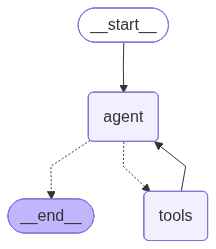

In [17]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
from langchain_core.messages import HumanMessage

message1 = [HumanMessage(content="Hello, how are you?")]

In [19]:
graph.invoke({"messages": message1})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='7637f34a-10dd-4b76-a86e-20292db47a1b'),
  AIMessage(content="I'm doing well, thanks — how can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 131, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CMBmqI1bvTKajBkVZEzXbiVn3R2Bt', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--96355c4c-17de-4399-8c31-d043b22d9453-0', usage_metadata={'input_tokens': 131, 'output_tokens': 22, 'total_tokens': 153, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [20]:
message2 = [HumanMessage(content="How is the weather in bangalore?")]

In [21]:
graph.invoke({"messages": message2})

{'messages': [HumanMessage(content='How is the weather in bangalore?', additional_kwargs={}, response_metadata={}, id='7555327d-011b-433b-8784-a63fa195eea3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TQfwm1N8A9xM64Hpnrv78lUK', 'function': {'arguments': '{"location":"Bengaluru, India"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 133, 'total_tokens': 225, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CMBnUqA5suMjDONcvlx4osiWS2VrJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--386bed6a-00b8-45ab-adf8-5ef7f7fc82ab-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengalur

In [22]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="What would you recommend to do in that city than?")
        ]
    }
)

{'messages': [HumanMessage(content='What would you recommend to do in that city than?', additional_kwargs={}, response_metadata={}, id='b5c623ad-67f9-4c16-98de-37ce4483fd86'),
  AIMessage(content='I don’t know which city you mean — could you tell me the city (and any dates)? I can give much better suggestions if you also tell me:\n\n- How many days you’ll be there\n- Your interests (food, history, outdoors, museums, nightlife, shopping, family/kids, etc.)\n- Budget (cheap, mid, splurge)\n- Traveling solo, as a couple, or with kids\n- Any mobility/health constraints\n\nIn the meantime, here are categories and popular activity ideas you can pick from:\n\n- Culture & history: guided walking tour, major museum(s), historic district, landmark viewpoints, local theater or classical concert.\n- Food & drink: food market or night market, street-food crawl, bakery/cafe hop, wine/beer tasting or vineyard visit, a recommended restaurant or cooking class.\n- Outdoors & nature: city park or botanic

## CheckPointers

In [23]:
from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()

In [24]:
workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile(checkpointer=checkpointer)

In [25]:
graph.invoke(
    {"messages": [HumanMessage(content="How is the weather in bangalore?")]},
    config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='HOw is the weather in bangalore?', additional_kwargs={}, response_metadata={}, id='ab2eb01d-14f3-4366-a5a5-00b9a1617fb0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zeA8HvIheilnvrGg6xf4DiUQ', 'function': {'arguments': '{"location":"Bangalore, India"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 134, 'total_tokens': 224, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CMBslmGwBp5ZLtafhUAUKiVvKTFqY', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7aaeb55f-5810-4c3e-b42d-701ce9efcfc7-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bangalor

In [28]:
res = graph.invoke(
    {"messages": [HumanMessage(content="What would you recommend to do in that city than?")]},
    config={"configurable": {"thread_id": 1}},
)

res

{'messages': [HumanMessage(content='HOw is the weather in bangalore?', additional_kwargs={}, response_metadata={}, id='ab2eb01d-14f3-4366-a5a5-00b9a1617fb0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zeA8HvIheilnvrGg6xf4DiUQ', 'function': {'arguments': '{"location":"Bangalore, India"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 134, 'total_tokens': 224, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CMBslmGwBp5ZLtafhUAUKiVvKTFqY', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7aaeb55f-5810-4c3e-b42d-701ce9efcfc7-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bangalor

In [29]:
print(res["messages"][-1].content)

Sure — here are quick, interest-based recommendations and short sample itineraries for a sunny day in Bangalore (32°C). Pick one and I can make it more detailed.

1) Gardens & easy morning
- What: Lalbagh Botanical Garden or Cubbon Park for a cool morning walk, then breakfast at a nearby cafe.
- Timing: Start before 8:00 AM to avoid heat.
- Why: Relaxing, photo-friendly, good for families or solo travelers.

2) Heritage & culture
- What: Bangalore Palace → Tipu Sultan’s Summer Palace → National Gallery of Modern Art or Government Museum.
- Timing: Museum/palace visits mid-morning; break for lunch indoors.
- Why: Learn local history and see colonial architecture.

3) Food-focused (local flavors)
- What: Breakfast at MTR or Veena Stores (rava idli/dosa), explore VV Puram Food Street in the evening, try filter coffee and local sweets.
- Timing: Breakfast early; street food in the cooler evening hours.
- Why: Best way to taste authentic Karnataka cuisine.

4) Microbreweries & nightlife
- W